# Demonstration 5: Free Choice Premium

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import FreeChoice
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
img_dir = os.path.join('..','figures')
%matplotlib inline

## Model-Free Temporal Difference Learning

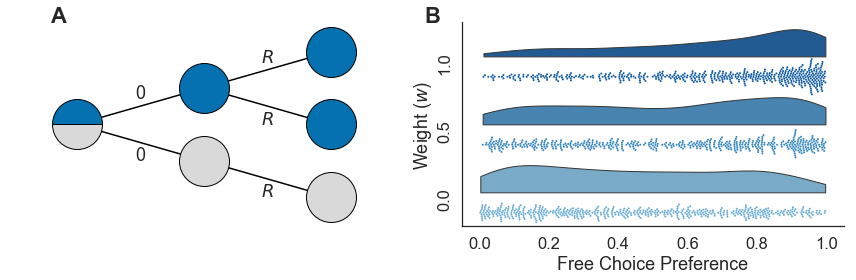

In [2]:
import ptitprince as pt
from pandas import DataFrame, read_csv
from sisyphus.mdp import ModelFree
from sisyphus.mdp._misc import softmax
from tqdm import tqdm
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
n_agents = 500
weights = [1.0, 0.5, 0.0]
rewards = [-1,1]
overwrite = False

## Define exploration schedule.
schedule = np.logspace(0,1,100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = FreeChoice(rewards=rewards)

f = os.path.join(img_dir, '05_choice.csv')
if not os.path.isfile(f) or overwrite:

    data = []
    for w in weights:

        ## Initialize agent.
        agent = ModelFree('pessimism', eta=0.1, gamma=1, w=w)

        for _ in tqdm(range(n_agents)):

            ## Solve for Q-values.
            agent = agent.fit(gym, schedule=schedule, overwrite=True)

            ## Compute choice likelihood.
            theta = softmax(agent.Q[:2] * schedule[-1])

            ## Store results.
            data.append( dict(w=w, theta=theta[0], pi=agent.pi[1]) )

    ## Convert to DataFrame.
    data = DataFrame(data)

    ## Fix labels.
    data['Choice'] = np.where(data.pi==1, 'Free', 'Fixed')
    data.to_csv(f, index=False)

else:
    
    ## Load data (if already saved).
    data = read_csv(f)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize figure.
fig, axes = plt.subplots(1,2,figsize=(12,4))
palette = sns.color_palette('Blues_r', n_colors=5)

## Plot environment.
gym.plot_free_choice(axes[0], free_color='#0571B0', fixed_color='0.85', edge_labels=True)
axes[0].annotate('A', (0,0), (0.1,1), 'axes fraction', fontsize=22, fontweight='bold')

## Plot simulations.
pt.half_violinplot('theta', 'w', data=data, order=weights, palette=palette, orient='h', 
                   scale='width', linewidth=1, cut=0, width=0.8, offset=0.3, inner=None, ax=axes[1])
sns.swarmplot('theta', 'w', data=data, order=weights, palette=palette, orient='h', 
              size=2, ax=axes[1])
axes[1].set(xlim=(-0.05,1.05), ylim=(2.2,-0.8), yticks=[-0.2, 0.8, 1.8], 
            xlabel='Free Choice Preference', ylabel=r'Weight ($w$)')
axes[1].set_yticklabels(weights, rotation=90, va='center')
axes[1].annotate('B', (0,0), (-0.1,1), 'axes fraction', fontsize=22, fontweight='bold')

# Finalize the figure
sns.despine(ax=axes[1])
plt.tight_layout()
plt.savefig(os.path.join(img_dir, '05_choice.png'), dpi=600)